In [5]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from causalinference import CausalModel
from sklearn.linear_model import LogisticRegression

import graphviz as gr

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", 6)

## 데이터 가져오기

In [6]:
data = pd.read_csv("lalonde_data.csv")

## 회귀 분석

In [7]:
TREAT = "treat"
FEATURE = ["age", "educ", "married", "re74"]

In [8]:
formula = f"{TREAT} ~ {' + '.join(FEATURE)}"
print(formula)

treat ~ age + educ + married + re74


In [9]:
lg_model = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
lg_model.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.6849,0.490,-1.396,0.163,-1.646,0.276
age,0.0124,0.011,1.181,0.238,-0.008,0.033
educ,0.0221,0.037,0.591,0.554,-0.051,0.095
married,-1.2208,0.237,-5.161,0.000,-1.684,-0.757
re74,-8.7e-05,2.21e-05,-3.929,0.000,-0.000,-4.36e-05


In [10]:
Propensity_Score = lg_model.predict(data[FEATURE])
data['Propensity_Score'] = Propensity_Score

Propensity_Score

0      0.230980
1      0.447041
2      0.488269
3      0.473447
4      0.475522
         ...   
609    0.445671
610    0.170054
611    0.493430
612    0.198220
613    0.428686
Length: 614, dtype: float64

## 회귀분석 기반 매칭

In [7]:
import pandas as pd
from scipy.spatial.distance import cdist

data['Propensity_Score'] = pd.to_numeric(data['Propensity_Score'])
data['pair'] = "NAN"
# 처치군과 대조군 나누기
treatment_group = data[data['treat'] == 1]
control_group = data[data['treat'] == 0]

# 매칭 결과를 저장할 딕셔너리
matching_result = {}

# 매칭되지 않은 대조군
remaining_controls = control_group.copy()

for index_treat, row_treat in treatment_group.iterrows():
    # 처치군의 각 행에 대해서 대조군과의 유사도 측정
    distances = cdist([row_treat[['Propensity_Score']].astype(float)], remaining_controls[['Propensity_Score']], metric='euclidean')
    
    # 유사도가 가장 작은 대조군의 index 찾기
    best_match_index = distances.argmin()
    matching_control_index = remaining_controls.iloc[best_match_index].name
    
    # 매칭 결과 저장
    matching_result[index_treat] = matching_control_index
     
    # 매칭된 대조군 제외
    remaining_controls.drop(index=matching_control_index, inplace=True)

for treat_index, control_index in matching_result.items():
    treatment_group.loc[treat_index, "pair"] = int(control_index)  
    control_group.loc[control_index, 'pair'] = int(treat_index) 

In [8]:
matched_control_group =  control_group[control_group['pair']!="NAN"]
unmatched_control_group = control_group[control_group['pair']=="NAN"]

In [9]:
treatment_group.describe()

,treat,age,educ,...,re75,re78,Propensity_Score
count,185.0,185.000000,185.000000,...,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,...,1532.055314,6349.143530,0.383238
std,0.0,7.155019,2.010650,...,3219.250870,7867.402218,0.124134
min,1.0,17.000000,4.000000,...,0.000000,0.000000,0.012945
25%,1.0,20.000000,9.000000,...,0.000000,485.229800,0.287525
50%,1.0,25.000000,11.000000,...,0.000000,4232.309000,0.437842
75%,1.0,29.000000,12.000000,...,1817.284000,9642.999000,0.467254
max,1.0,48.000000,16.000000,...,25142.240000,60307.930000,0.543398


In [10]:
matched_control_group.describe()

,treat,age,educ,...,re75,re78,Propensity_Score
count,185.0,185.000000,185.000000,...,185.000000,185.000000,185.000000
mean,0.0,25.372973,10.524324,...,1219.906496,5272.999691,0.376183
std,0.0,10.228175,2.813149,...,2230.169769,5974.797220,0.120044
min,0.0,16.000000,1.000000,...,0.000000,0.000000,0.027455
25%,0.0,18.000000,9.000000,...,0.000000,0.000000,0.283778
50%,0.0,21.000000,11.000000,...,218.419400,3367.739000,0.428686
75%,0.0,30.000000,12.000000,...,1448.371000,7759.542000,0.445671
max,0.0,55.000000,18.000000,...,17806.550000,25564.670000,0.559455


In [11]:
unmatched_control_group.describe()

,treat,age,educ,...,re75,re78,Propensity_Score
count,244.0,244.000000,244.000000,...,244.000000,244.000000,244.000000
mean,0.0,30.045082,10.016393,...,3411.635755,8281.573265,0.182406
std,0.0,10.782646,2.873130,...,3638.916008,7922.144347,0.122063
min,0.0,16.000000,0.000000,...,0.000000,0.000000,0.029557
25%,0.0,21.000000,8.000000,...,205.887100,833.068375,0.089860
50%,0.0,27.000000,11.000000,...,2434.839000,6285.510000,0.147602
75%,0.0,38.250000,12.000000,...,5603.709500,14213.142500,0.253148
max,0.0,55.000000,17.000000,...,18347.230000,25564.670000,0.421878


## SDM 계산

In [12]:
# for SMD score
SMD_before_matching_data = abs(treatment_group[FEATURE].mean() - control_group[FEATURE].mean()) / data[FEATURE].std()


matched_data = pd.concat([treatment_group, matched_control_group])
SMD_after_matching_data = abs(treatment_group[FEATURE].mean() - matched_control_group[FEATURE].mean()) / matched_data[FEATURE].std()

In [13]:
SMD_before_matching_data

age        0.224071
educ       0.042048
married    0.656217
re74       0.543946
dtype: float64

In [14]:
SMD_after_matching_data

age        0.050270
educ       0.073005
married    0.080170
re74       0.042898
dtype: float64

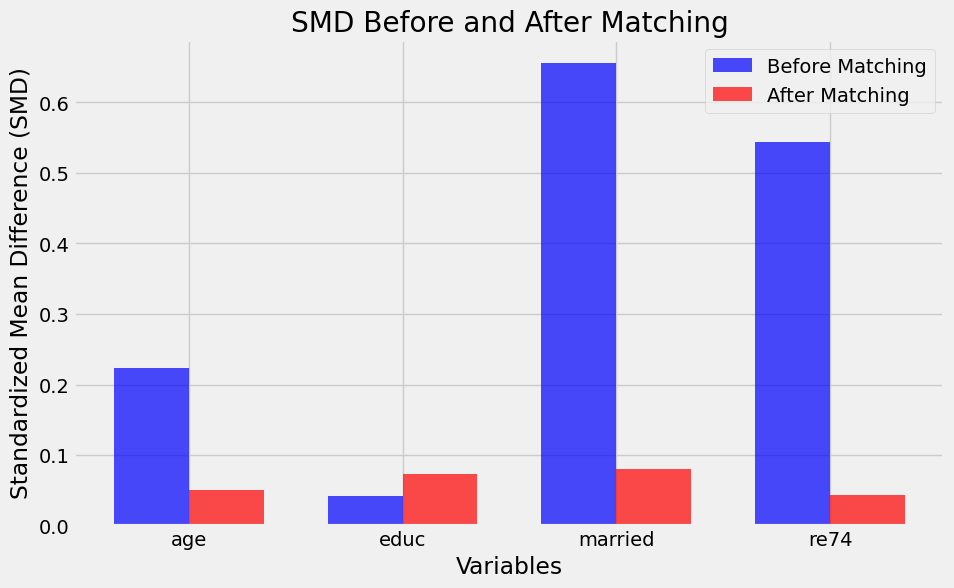

In [15]:
# x 좌표
variables = FEATURE
x = np.arange(len(variables))

# 너비 설정
width = 0.35

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))

# 매칭 전 SMD
bars1 = ax.bar(x - width/2, SMD_before_matching_data, width, label='Before Matching', color='blue', alpha=0.7)

# 매칭 후 SMD
bars2 = ax.bar(x + width/2, SMD_after_matching_data, width, label='After Matching', color='red', alpha=0.7)

# 레이블 및 타이틀 설정
ax.set_xlabel('Variables')
ax.set_ylabel('Standardized Mean Difference (SMD)')
ax.set_title('SMD Before and After Matching')
ax.set_xticks(x)
ax.set_xticklabels(variables)
ax.legend()

# 그래프 표시
plt.show()

## 시각화


(array([ 53.,  68.,  56.,  43.,  18.,  17.,  20., 115.,  30.,   9.]),
 array([0.02745549, 0.08065549, 0.13385549, 0.18705549, 0.24025549,
        0.29345549, 0.3466555 , 0.3998555 , 0.4530555 , 0.5062555 ,
        0.5594555 ]),
 <BarContainer object of 10 artists>)

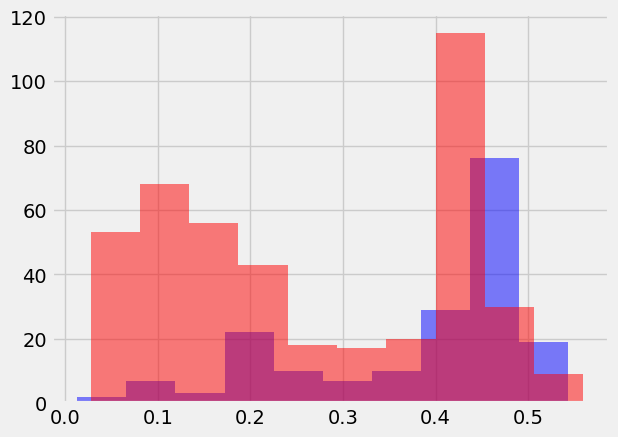

In [16]:
plt.hist(treatment_group['Propensity_Score'], alpha=0.5, label='Treatment Group', color='blue')
plt.hist(control_group['Propensity_Score'], alpha=0.5, label='Control Group', color='red')

(array([ 5.,  5.,  5., 25.,  7.,  6., 10., 83., 30.,  9.]),
 array([0.02745549, 0.08065549, 0.13385549, 0.18705549, 0.24025549,
        0.29345549, 0.3466555 , 0.3998555 , 0.4530555 , 0.5062555 ,
        0.5594555 ]),
 <BarContainer object of 10 artists>)

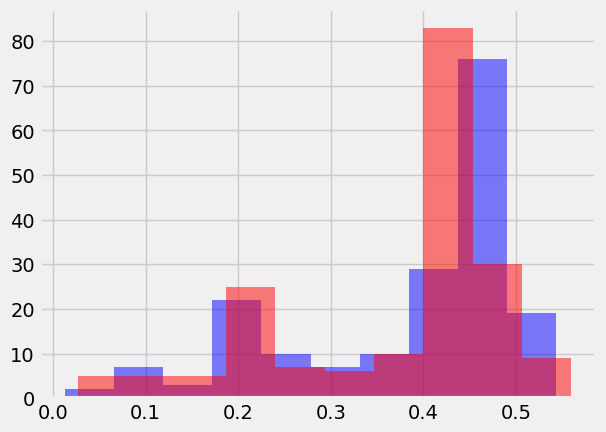

In [17]:
plt.hist(treatment_group['Propensity_Score'], alpha=0.5, label='Treatment Group', color='blue')
plt.hist(matched_control_group['Propensity_Score'], alpha=0.5, label='Control Group', color='red')

## 통계 검정

In [18]:
import scipy.stats as stats

In [19]:
treat_group = matched_data[matched_data['treat'] == 1]['re78']
control_group = matched_data[matched_data['treat'] == 0]['re78']

# t-검정 수행
t_stat, p_value = stats.ttest_ind(treat_group, control_group)

# 결과 출력
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

t-statistic: 1.4816449346303109
p-value: 0.13929053366638375


In [20]:
treat_group.mean(), control_group.mean()

(6349.143530270271, 5272.9996905405405)

In [37]:
data = pd.read_csv("lalonde_data.csv")

In [38]:
data

,ID,treat,age,...,re74,re75,re78
0,NSW1,1,37,...,0.0,0.0,9930.0460
1,NSW2,1,22,...,0.0,0.0,3595.8940
2,NSW3,1,30,...,0.0,0.0,24909.4500
3,NSW4,1,27,...,0.0,0.0,7506.1460
4,NSW5,1,33,...,0.0,0.0,289.7899
...,...,...,...,...,...,...,...
609,PSID425,0,18,...,0.0,0.0,10150.5000
610,PSID426,0,24,...,0.0,0.0,19464.6100
611,PSID427,0,21,...,0.0,0.0,0.0000
612,PSID428,0,32,...,0.0,0.0,187.6713


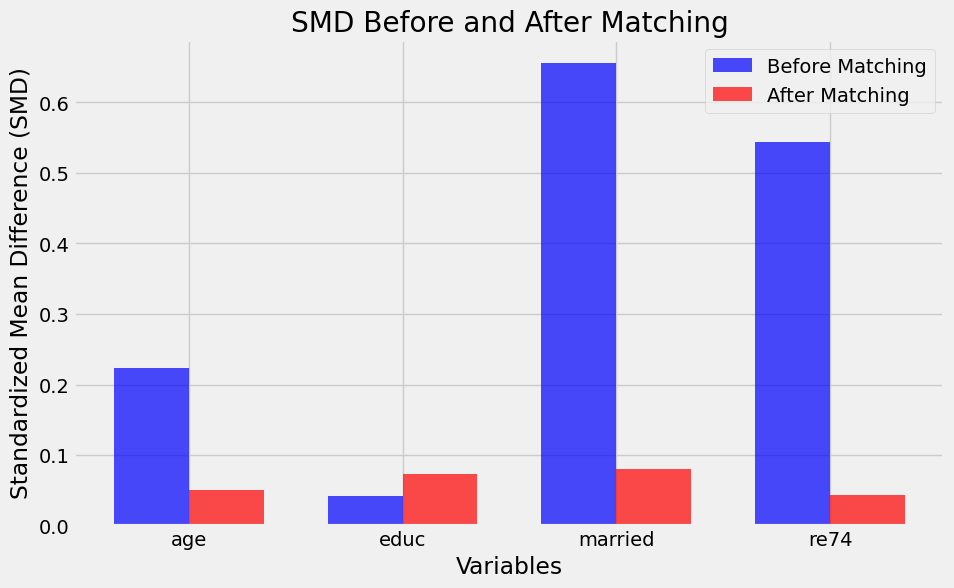

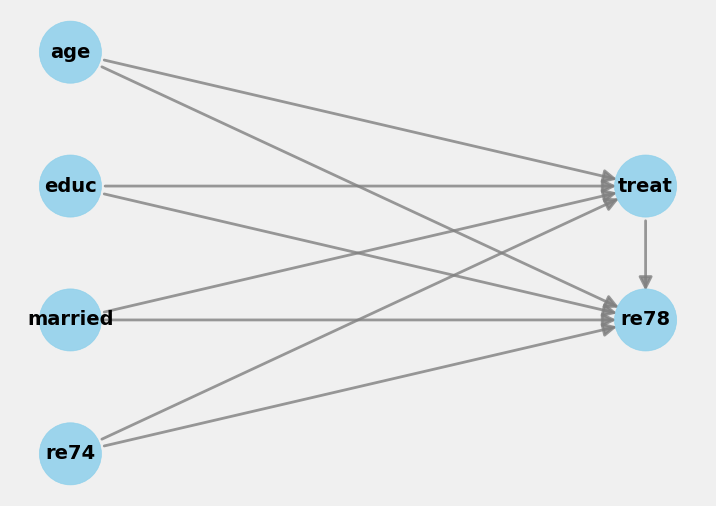

ATE (Average Treatment Effect): -952.728857084692
Refute: Use a Placebo Treatment
Estimated effect:-952.728857084692
New effect:-16.825574479478846
p value:0.92

Refute: Add a random common cause
Estimated effect:-952.728857084692
New effect:-952.7288570846919
p value:1.0



In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.spatial.distance import cdist
from dowhy import CausalModel


# 성향 점수 계산
TREAT = "treat"
FEATURE = ["age", "educ", "married", "re74"]
data['outcome'] = data['re74']

formula = f"{TREAT} ~ {' + '.join(FEATURE)}"
lg_model = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()

Propensity_Score = lg_model.predict(data[FEATURE])
data['Propensity_Score'] = Propensity_Score

# 회귀분석 기반 매칭
data['Propensity_Score'] = pd.to_numeric(data['Propensity_Score'])
data['pair'] = "NAN"

# 처치군과 대조군 나누기
treatment_group = data[data['treat'] == 1]
control_group = data[data['treat'] == 0]

# 매칭 결과를 저장할 딕셔너리
matching_result = {}

# 매칭되지 않은 대조군
remaining_controls = control_group.copy()

for index_treat, row_treat in treatment_group.iterrows():
    # 처치군의 각 행에 대해서 대조군과의 유사도 측정
    distances = cdist([row_treat[['Propensity_Score']].astype(float)], remaining_controls[['Propensity_Score']], metric='euclidean')

    # 유사도가 가장 작은 대조군의 index 찾기
    best_match_index = distances.argmin()
    matching_control_index = remaining_controls.iloc[best_match_index].name

    # 매칭 결과 저장
    matching_result[index_treat] = matching_control_index

    # 매칭된 대조군 제외
    remaining_controls.drop(index=matching_control_index, inplace=True)

for treat_index, control_index in matching_result.items():
    treatment_group.loc[treat_index, "pair"] = int(control_index)
    control_group.loc[control_index, 'pair'] = int(treat_index)

matched_control_group = control_group[control_group['pair'] != "NAN"]
unmatched_control_group = control_group[control_group['pair'] == "NAN"]

# 매칭 전후의 표준화 평균 차이 (SMD) 계산
SMD_before_matching_data = abs(treatment_group[FEATURE].mean() - control_group[FEATURE].mean()) / data[FEATURE].std()
matched_data = pd.concat([treatment_group, matched_control_group])
SMD_after_matching_data = abs(treatment_group[FEATURE].mean() - matched_control_group[FEATURE].mean()) / matched_data[FEATURE].std()

# x 좌표
variables = FEATURE
x = np.arange(len(variables))

# 너비 설정
width = 0.35

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))

# 매칭 전 SMD
bars1 = ax.bar(x - width/2, SMD_before_matching_data, width, label='Before Matching', color='blue', alpha=0.7)

# 매칭 후 SMD
bars2 = ax.bar(x + width/2, SMD_after_matching_data, width, label='After Matching', color='red', alpha=0.7)

# 레이블 및 타이틀 설정
ax.set_xlabel('Variables')
ax.set_ylabel('Standardized Mean Difference (SMD)')
ax.set_title('SMD Before and After Matching')
ax.set_xticks(x)
ax.set_xticklabels(variables)
ax.legend()

# 그래프 표시
plt.show()

# DoWhy 인과 추론
model = CausalModel(
    data=data,
    treatment='treat',
    outcome='re78',
    common_causes=FEATURE
)

# 인과 모형 시각화
model.view_model()

# 성향 점수 매칭을 사용하여 인과 효과 추정
identified_estimand = model.identify_effect()
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_matching")

# 결과 출력
print(f'ATE (Average Treatment Effect): {estimate.value}')

# 결과 해석 및 refutation
refute_placebo = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter"
)
print(refute_placebo)

refute_random = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="random_common_cause"
)
print(refute_random)